# Overview

SR Legacy data: https://fdc.nal.usda.gov/fdc-datasets/FoodData_Central_sr_legacy_food_csv_%202019-04-02.zip
<br/>
Supporting data: https://fdc.nal.usda.gov/fdc-datasets/FoodData_Central_Supporting_Data_csv_2022-10-28.zip

### Files

SR Legacy
* `all_downloaded_table_records_counts.csv` contains the number of entries in each data file
* `food_attribute.csv` contains attributes that are associated with some foods
* `food_nutrient_conversion_factor.csv` contains the multiplicative factors to be used when calculating energy from macronutrients for a specific food (why is is not always the same?)
* `food_nutrient.csv` contains the nutritional information for each food
* `food_portion.csv` contains the measures of portions for survey foods
* `food_protein_conversion_factor.csv` contains the multiplicative factor used to calculate protein from nitrogen
* `food_update_log.csv` contains the historical record of an update of food data
* `food.csv` contains the mapping from fdc_id to description
* `sr_legacy_food.csv` contains the fdc_id for each entry

Supporting data
* `nutrient.csv` contains the mapping from nutrient_id to description and unit

### Variables

* `fdc_id` is the food ID
* `nutrient_id` is the nutrient ID

In [200]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import percentileofscore as calcPercentile
import json
import math
import re
%config InlineBackend.figure_format='retina'

fdc_path='../../FoodData_Central_Supporting_Data_csv_2022-10-28'
sr_legacy_path='../../FoodData_Central_sr_legacy_food_csv_ 2019-04-02'

In [201]:
food=pd.read_csv(f'{sr_legacy_path}/food.csv')
food_nutrient=pd.read_csv(f'{sr_legacy_path}/food_nutrient.csv')
nutrient_info=pd.read_csv(f'{fdc_path}/nutrient.csv')
food_category=pd.read_csv(f'{fdc_path}/food_category.csv')

### i. save dict from 'id' to 'name' in JSON file

In [202]:
file=open('nutrient_name.json','w')
file.write(json.dumps(nutrient_info[['id','name']].set_index('id').to_dict()['name']))
file.close()

In [203]:
print(food['fdc_id'].nunique(),'unique foods in SR Legacy')
print(food_nutrient['nutrient_id'].nunique(),'unique nutrients in SR Legacy')

7793 unique foods in SR Legacy
149 unique nutrients in SR Legacy


# 1. Save amount data for each nutrient to calculate percentiles

### i. groupby nutrient_id to create a dataset for calculating percentiles

In [204]:
nutrient_amounts=food_nutrient[['nutrient_id','amount','fdc_id']].groupby('nutrient_id')
nutrient_id_to_name=nutrient_info[['id','name']].set_index('id').to_dict()['name']
food_id_to_description=pd.Series(food.description.values,index=food.fdc_id).to_dict()
nutrient_id_to_unit=pd.Series(nutrient_info.unit_name.values,index=nutrient_info.id).to_dict()

In [223]:
category_id_to_description=pd.Series(food_category['description'].values,index=food_category['id']).to_dict()
food['food_category_name']=food.apply(lambda x:category_id_to_description[x['food_category_id']],axis=1)
fdc_id_to_food_category=pd.Series(food['food_category_name'].values,index=food.fdc_id).to_dict()

In [15]:
# calculate the percentile of an amount, using the data for each nutrient
print(calcPercentile(nutrient_amounts.get_group(1003)['amount'],2),'%')

23.11048376748364 %


### ii. save as JSON

In [28]:
amounts={}
for k in nutrient_amounts.groups.keys():
    amounts[k]={"data":list(nutrient_amounts.get_group(k)['amount']),"labels":list(nutrient_amounts.get_group(k)['fdc_id'])}

In [34]:
file=open('sr_fdc_id_to_description.json','w')
file.write(json.dumps(food_id_to_description))
file.close()

In [21]:
file=open('nutrient_amounts_labels.json','w')
file.write(json.dumps(amounts))
file.close()

In [44]:
file=open('nutrient_id_to_unit.json','w')
file.write(json.dumps(nutrient_id_to_unit))
file.close()

In [224]:
file=open('fdc_id_to_food_category.json','w')
file.write(json.dumps(fdc_id_to_food_category))
file.close()

### iii. visualize nutrient data

In [15]:
file=open('nutrient_amounts.json','r')
data=json.loads(file.read())
file.close()

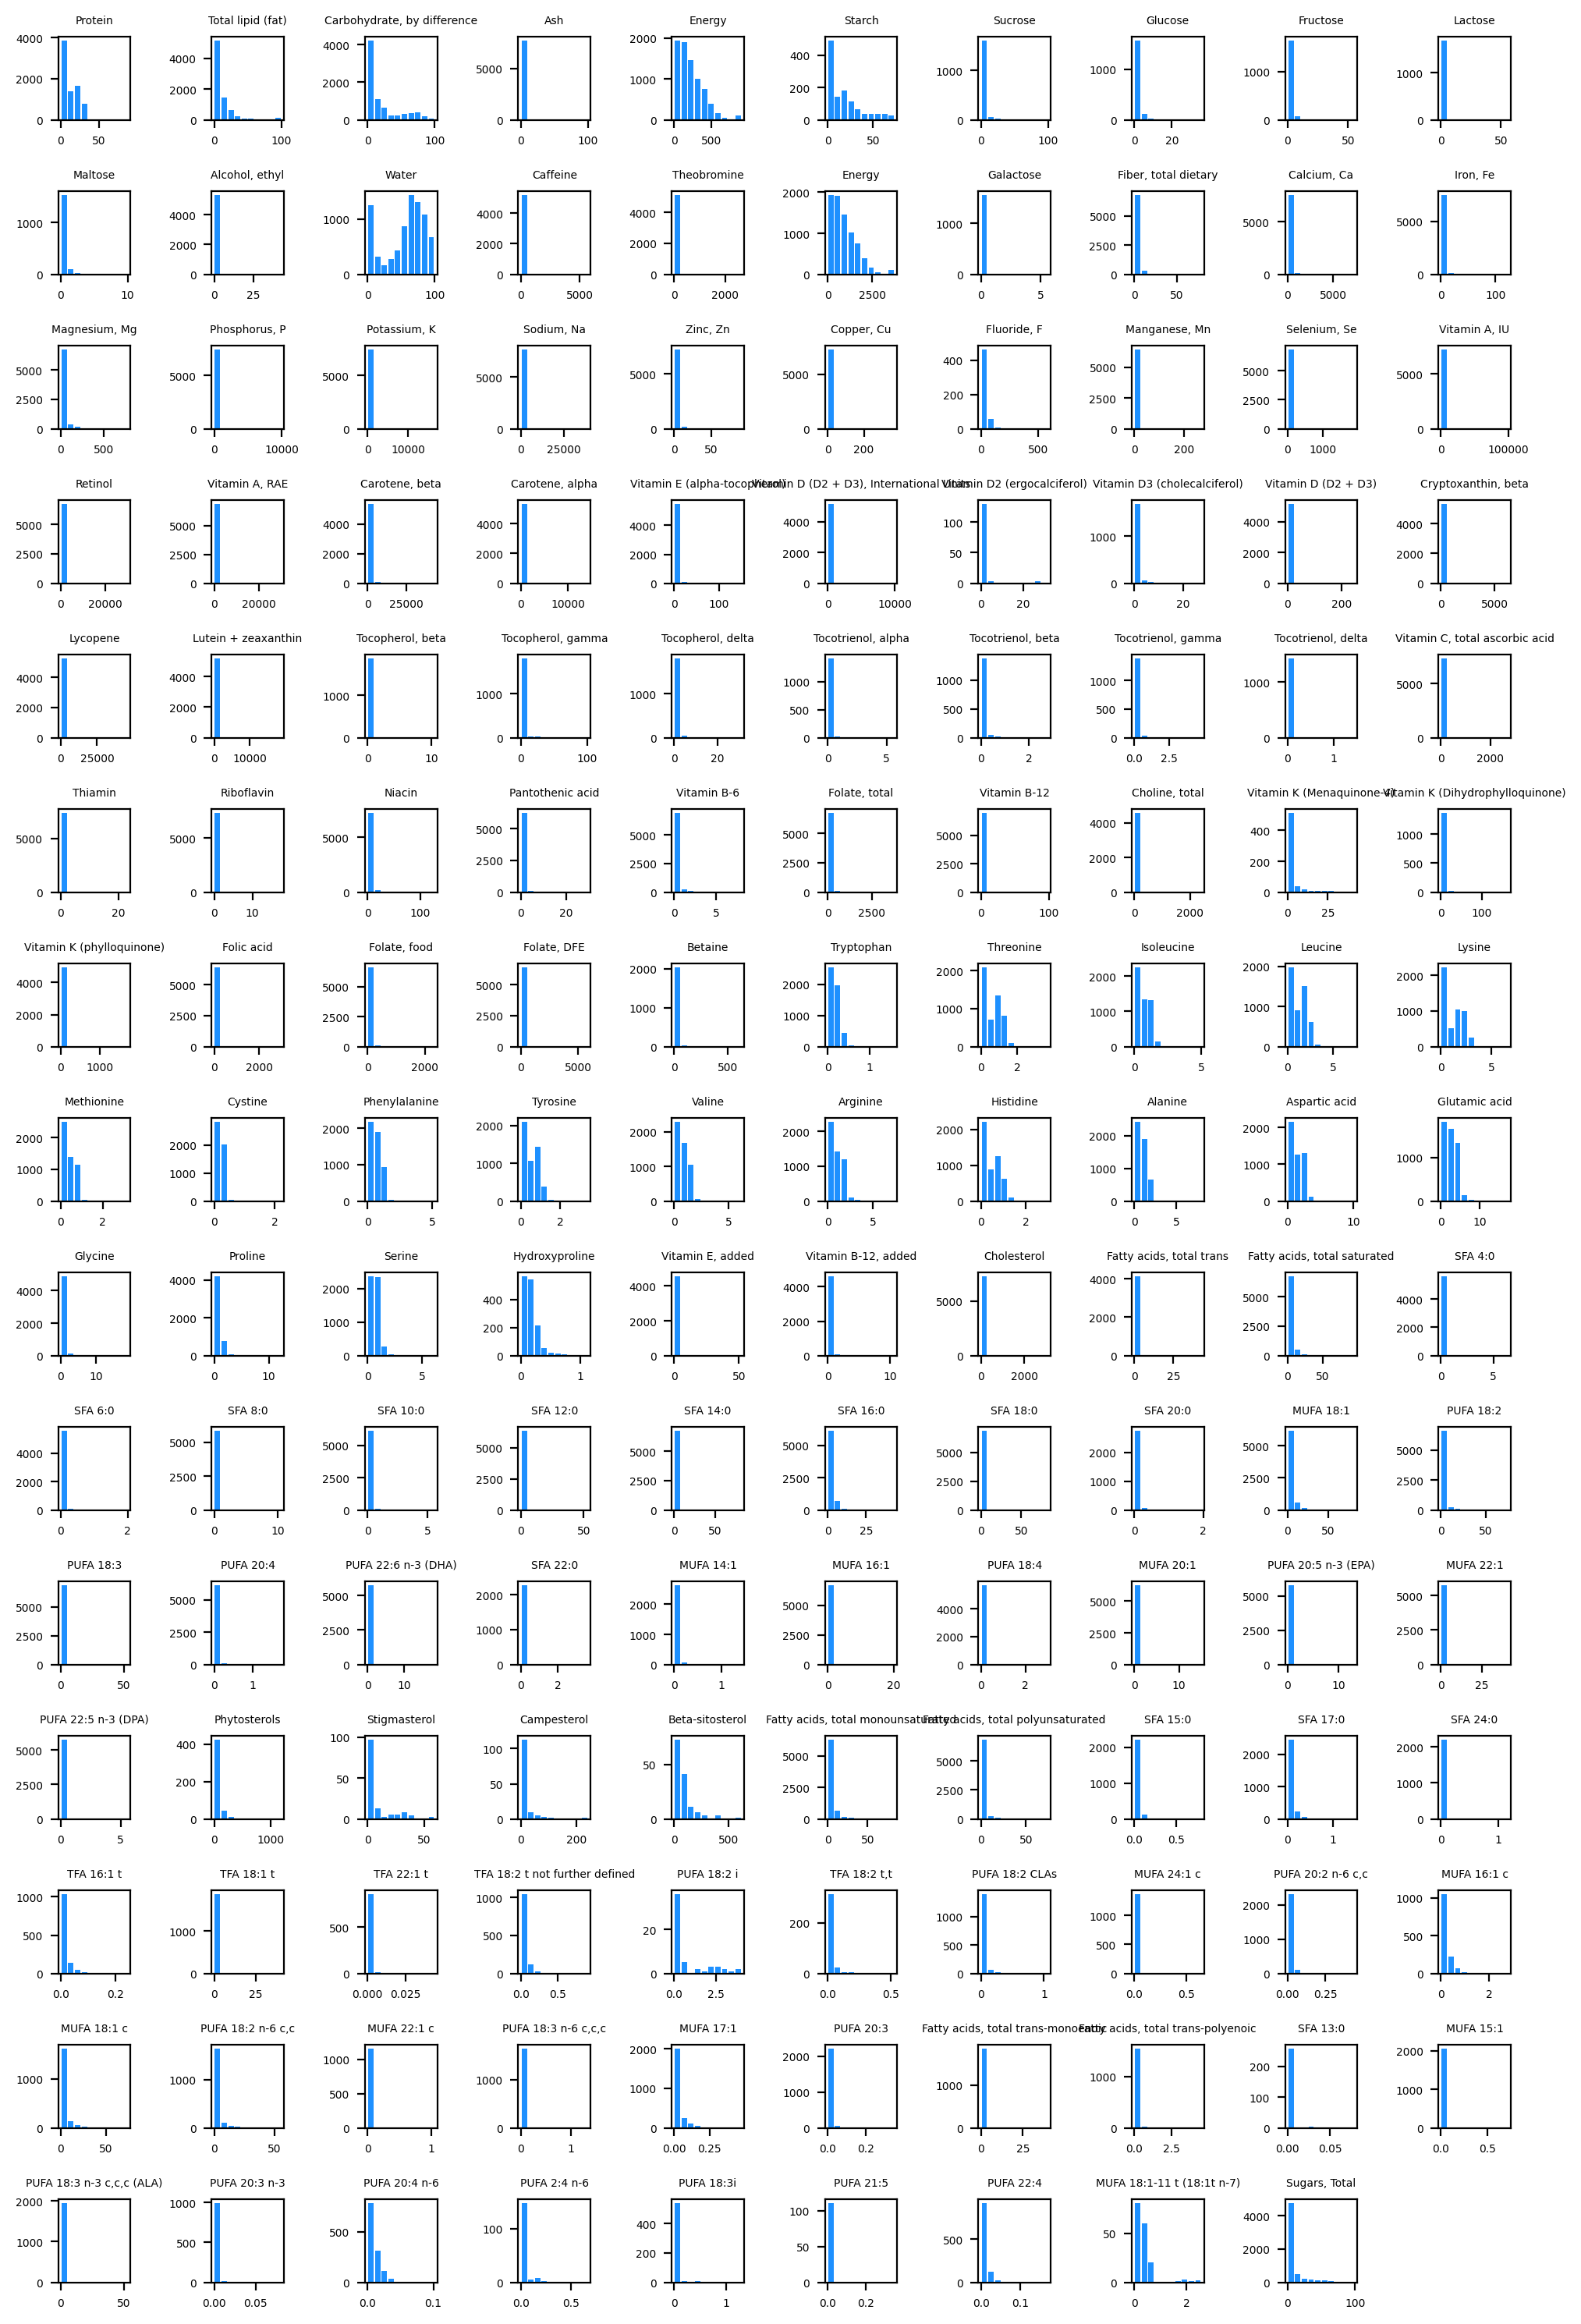

In [16]:
rows=15
cols=10
fig,ax=plt.subplots(nrows=rows,ncols=cols,figsize=(cols,rows))
fig.set_tight_layout(True)
fontsize=5

for i in list(range(rows*cols)):
    if i>=len(data):
        ax[math.floor(i/cols),i%cols].set_visible(False)
        break
    ax[math.floor(i/cols),i%cols].set_title(nutrient_id_to_name[int(list(data.keys())[i])],fontsize=fontsize)
    ax[math.floor(i/cols),i%cols].hist(data[list(data.keys())[i]],rwidth=0.8,bins=10,color='dodgerblue')
    ax[math.floor(i/cols),i%cols].tick_params(labelsize=fontsize)
#fig.savefig('nutrient_amounts.png',dpi=300)

### iv. visualize number of entries contributing to each nutrient dataset

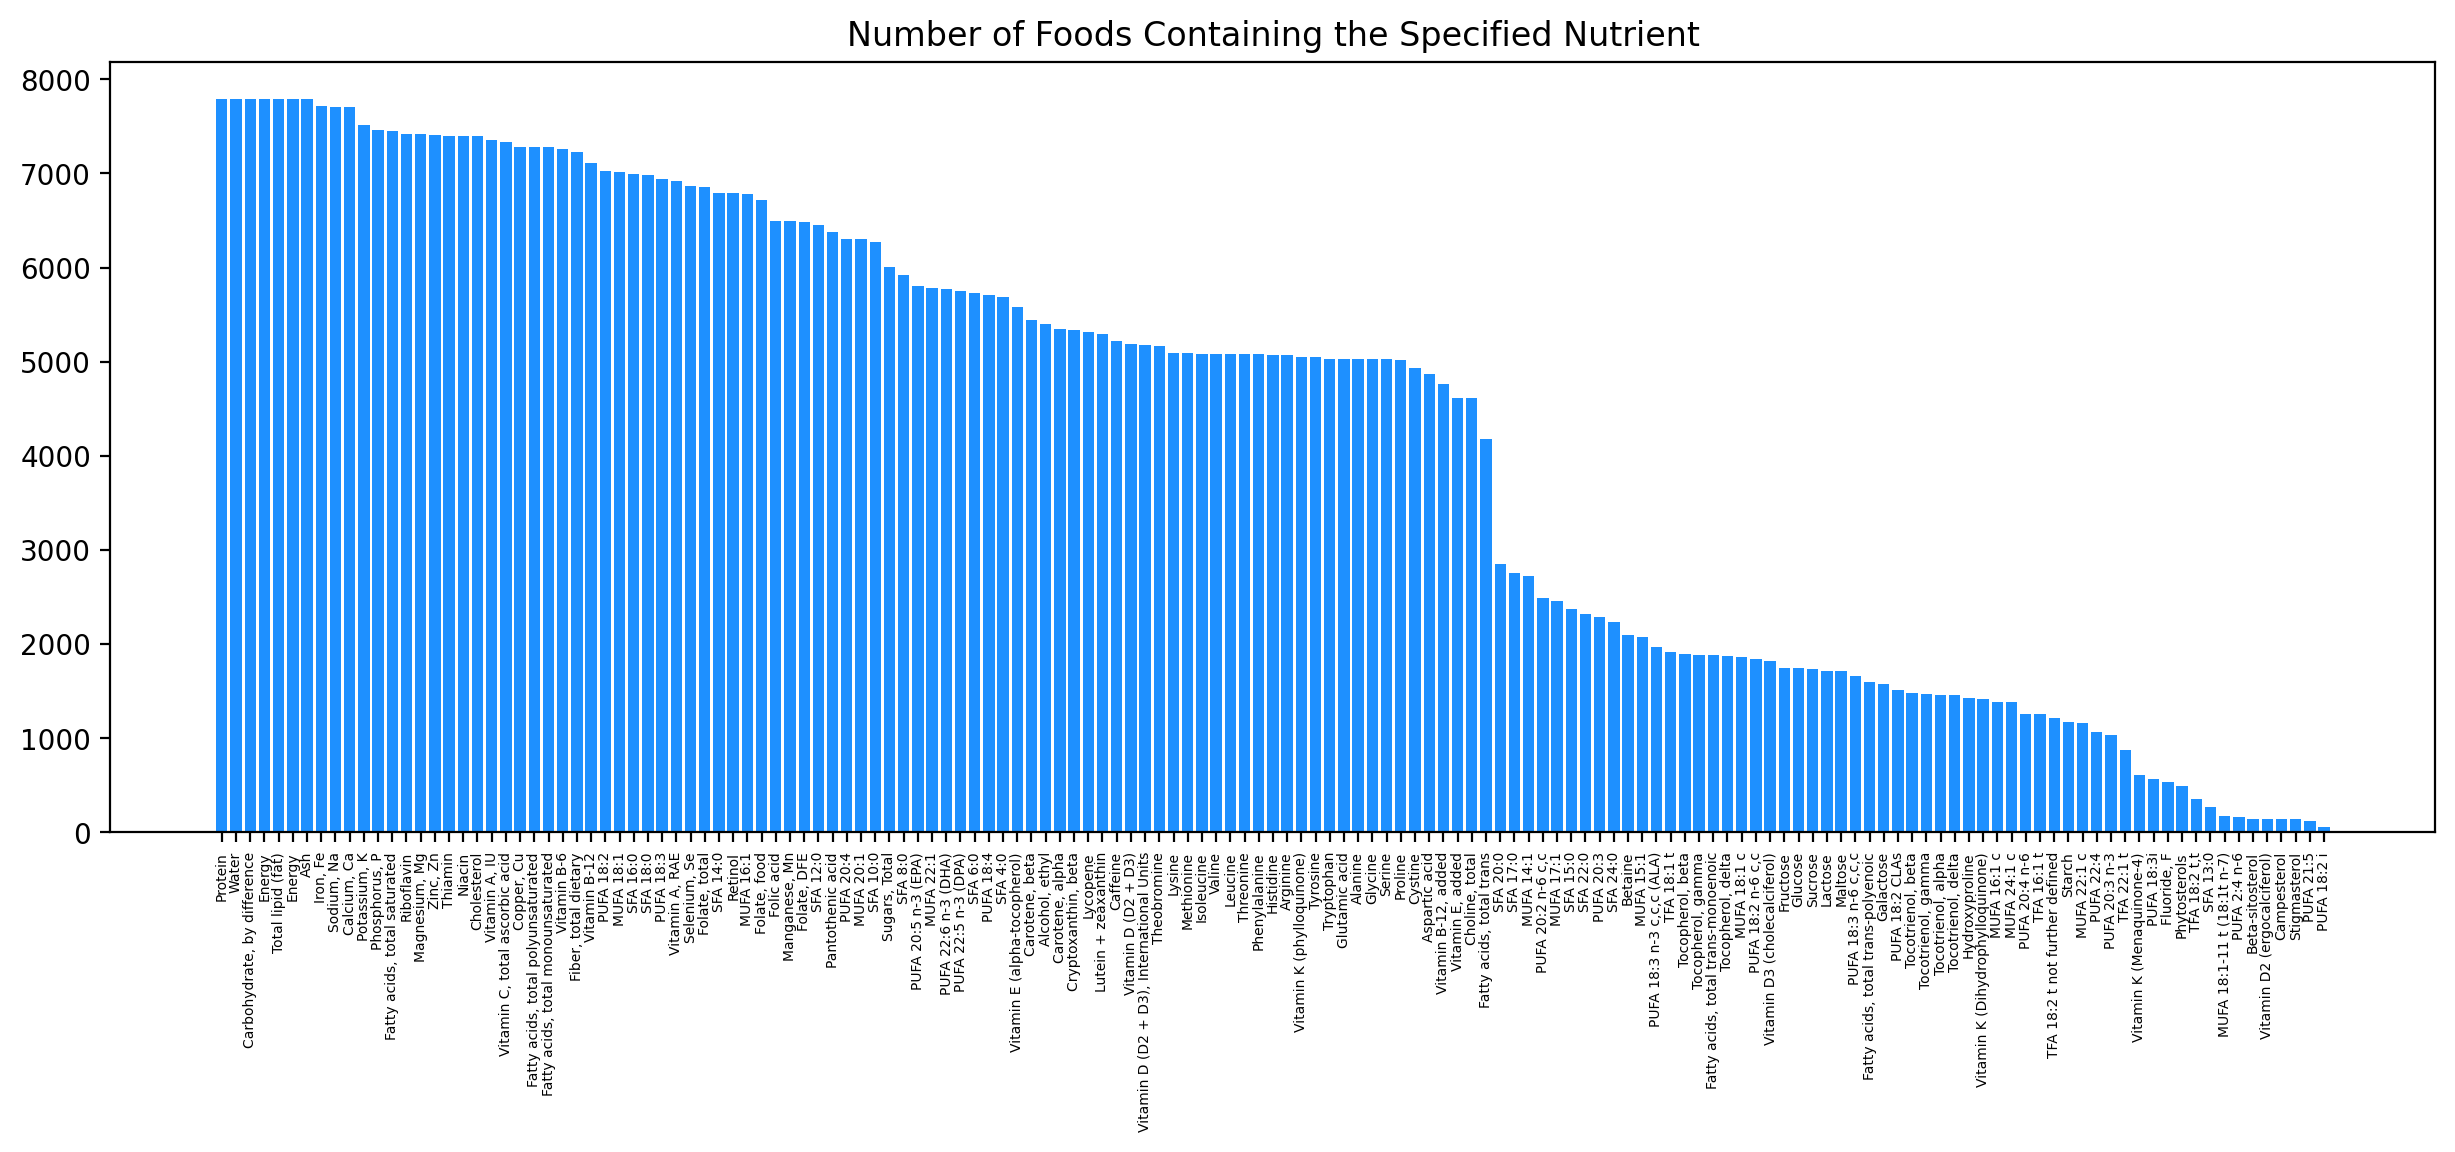

In [17]:
counts=nutrient_amounts.size()
counts.sort_values(ascending=False,inplace=True)

labels=map(lambda x:nutrient_id_to_name[x],counts.index)

fig,ax=plt.subplots(figsize=(15,5))
ax.bar(list(range(len(counts))),counts,color='dodgerblue')

ax.set_title('Number of Foods Containing the Specified Nutrient')
ax.set_xticks(list(range(len(counts))))
ax.set_xticklabels(labels);
ax.tick_params(axis='x',rotation=90,labelsize=5)

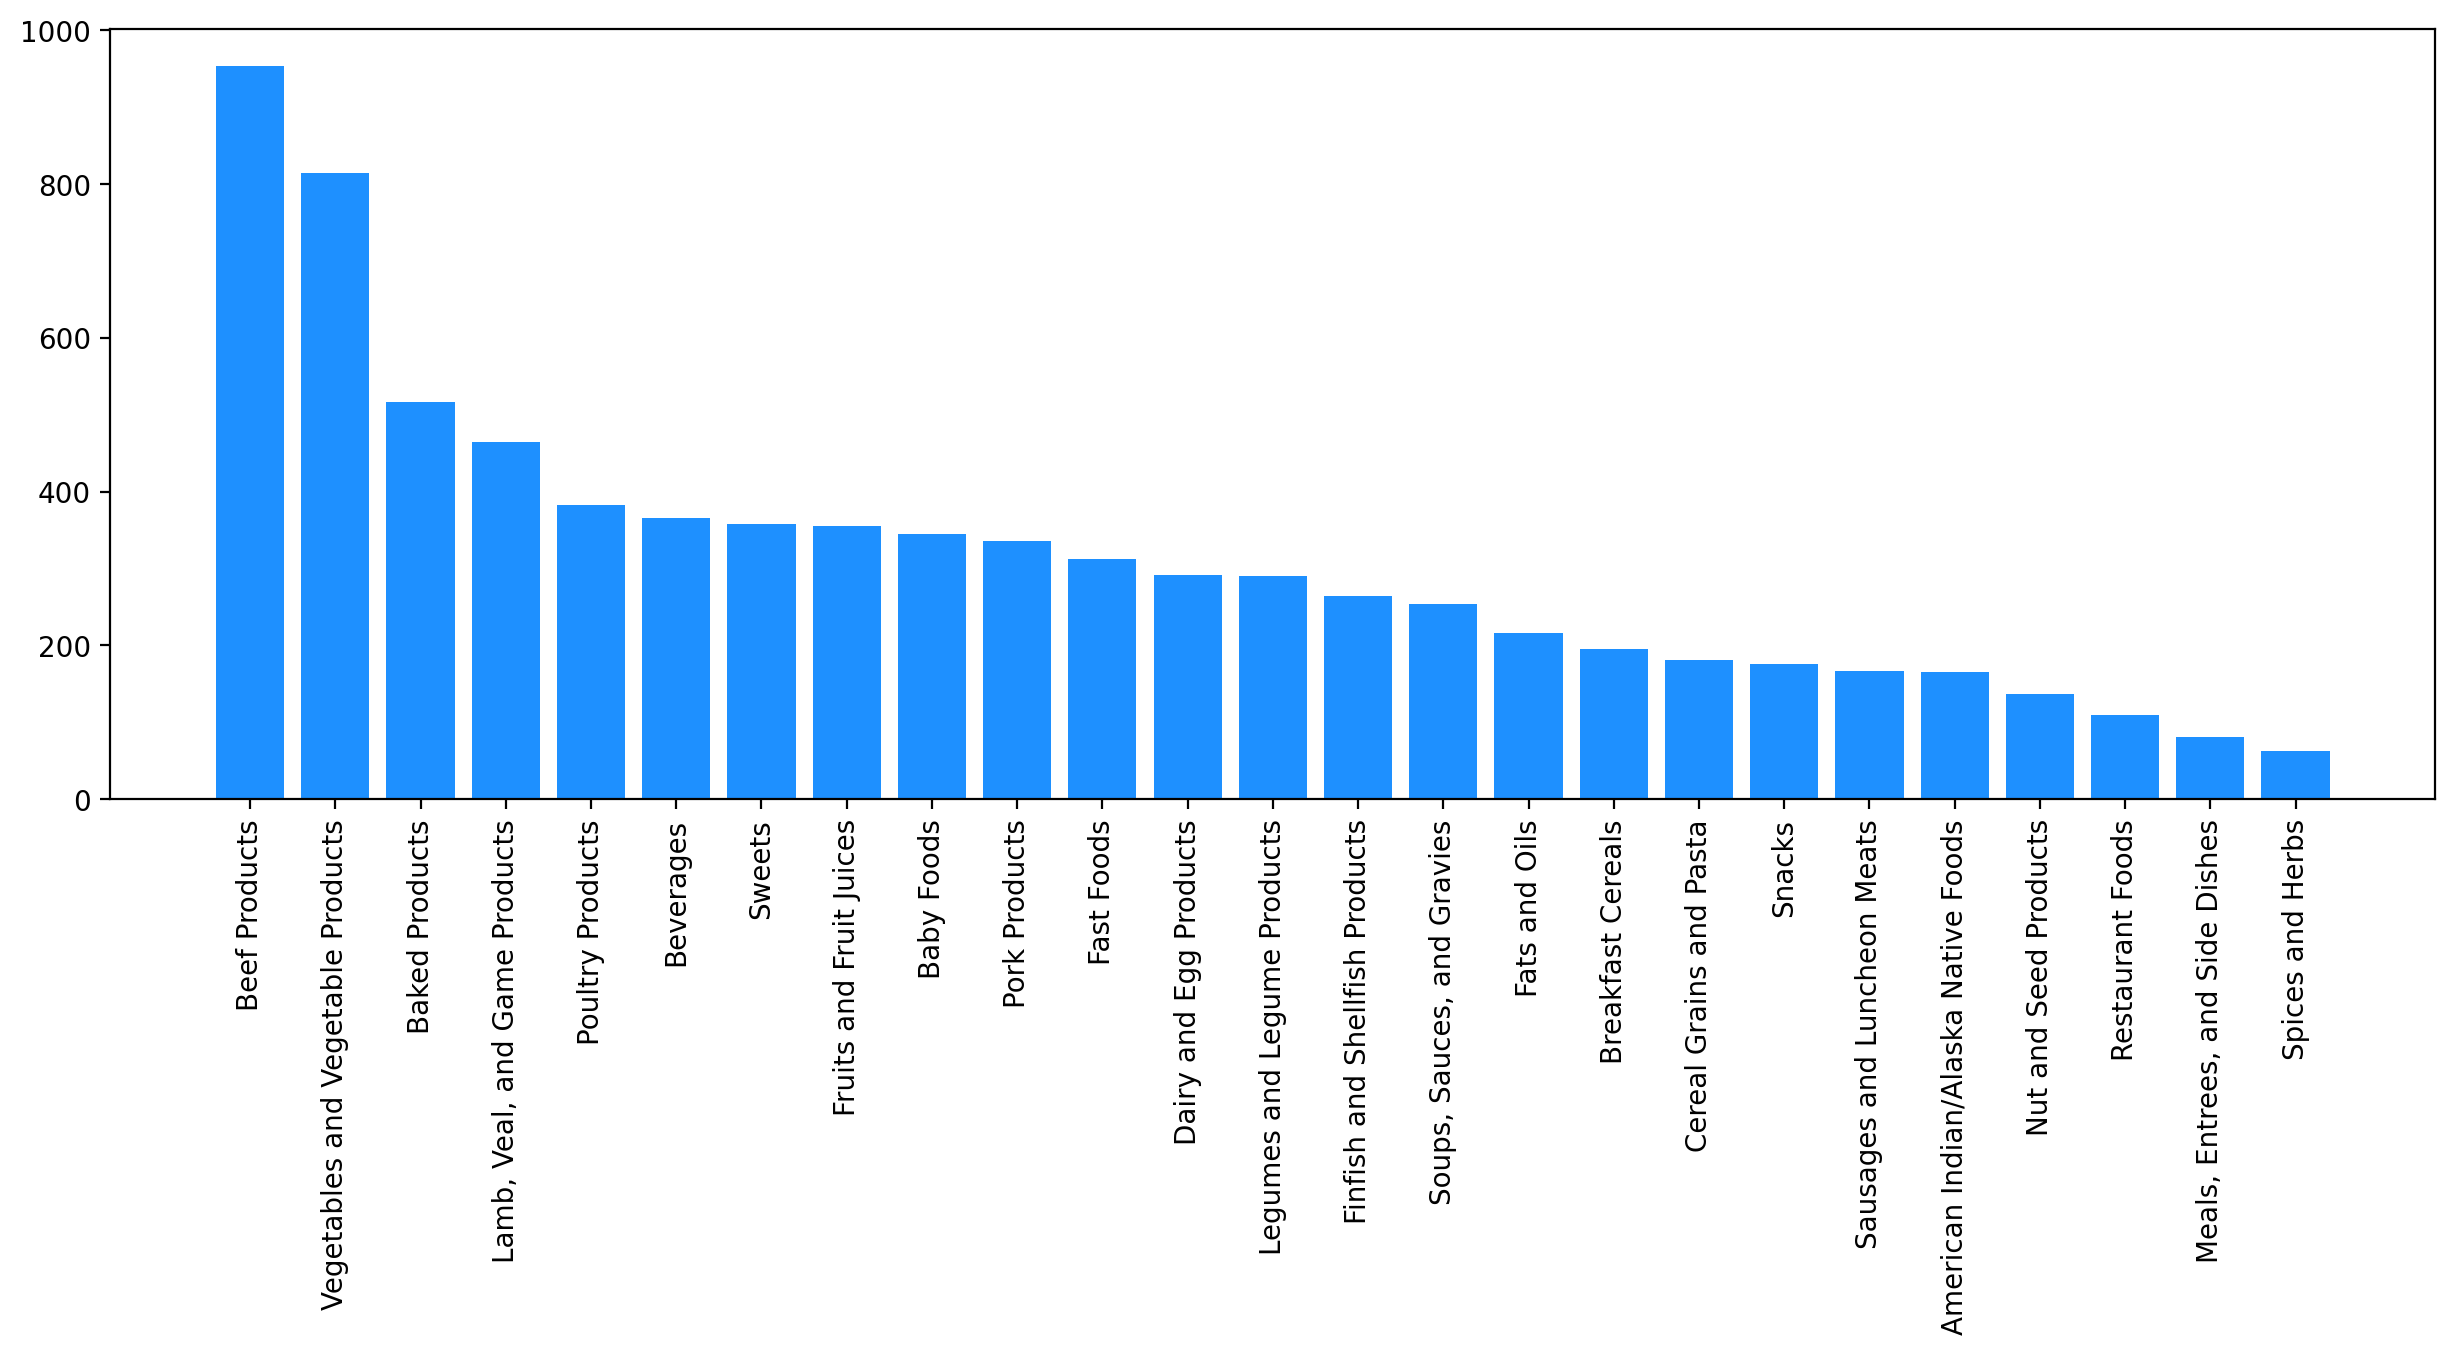

In [217]:
category_id_to_description=pd.Series(food_category['description'].values,index=food_category['id']).to_dict()

category_counts=food['food_category_id'].value_counts().sort_values(ascending=False).to_dict()
labels=list(map(lambda x:category_id_to_description[x],category_counts.keys()))

fig,ax=plt.subplots(figsize=(15,5))
ax.bar(list(range(len(labels))),category_counts.values(),color='dodgerblue')
ax.set_xticks(list(range(len(labels))))
ax.set_xticklabels(labels);
ax.tick_params(axis='x',rotation=90)